# Install

In [1]:
!pip install unidecode
!git clone https://github.com/lucas-castrow/StreamFuels
import os
import sys

os.chdir("/content/")
os.chdir('/content/StreamFuels')
sys.path.append('/content/StreamFuels')

!python3 /content/StreamFuels/setup.py install

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.3 MB/s eta 0:00:00
Cloning into 'StreamFuels'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 145 (delta 77), reused 94 (delta 33), pack-reused 0 (from 0)
Receiving objects: 100% (145/145), 99.58 KiB | 999.00 KiB/s, done.
Resolving deltas: 100% (77/77), done.
running install
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  

# Import DatasetLoader from StreamFuels

In [32]:
from streamfuels.datasets import DatasetLoader
loader = DatasetLoader()

# Additional libraries for this notebook
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

!pip install stumpy
import stumpy

# Function to normalize (z-score) a series to have zero mean and unit std
def znorm(series):
    mean = np.mean(series)
    std = np.std(series)
    if std == 0:
        return np.zeros_like(series)
    return (series - mean) / std

colors = [
    'orange',
    'purple',
    'green',
    'red',
    'blue',
    'brown',
    'pink',
    'gray',
    'olive',
    'cyan'
]

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/streamfuels-0.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/tqdm-4.65.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


# Motif discovery

Analysis on the Monthly Fuel Sales by State dataset

In [34]:
result, flag = loader.monthly_sales_state()
df, metadata = loader.read_tsf(path_tsf=result)

dataset downloaded at: ./monthly_fuel_sales_by_state.tsf


Discoverying motifs in a single example, i.e., unidimensional time series

Specifically, we will analyze the Ethanol sales in the Rio de Janeiro state

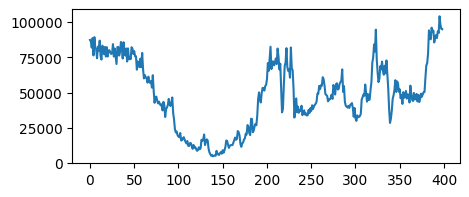

In [35]:
series = np.array(df[(df['state_code'] == 'RJ') & (df['product'] == 'ethanol')]['series_value'].values.tolist())[0]
series = series[24:]
plt.figure(figsize=(5,2))
plt.plot(series)

Finding the top-10 ($k=10$) motifs with patterns comprising 6 months ($m=6$) using the Matrix Profile approach with Stump algorithm

In [36]:
m = 6
k = 10
mp = stumpy.stump(series, m)
motif_distances, motif_indices = stumpy.motifs(series, mp[:, 0], max_motifs=k)

Highlighting the positions of discovered motifs in the unidimensional series

Each group of motifs is represented by a different color

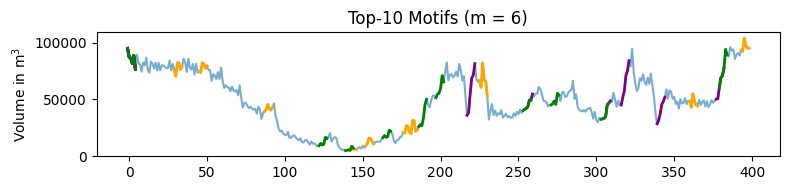

In [37]:
plt.figure(figsize=(8, 2))
plt.plot(series, alpha=0.6)

for i in range(len(motif_indices)):
    for idx in motif_indices[i]:
        motif_segment = np.arange(idx, idx + m)
        plt.plot(motif_segment, series[motif_segment], color=colors[i % len(colors)], linewidth=2)

plt.ylabel('Volume in m$^3$')
plt.title(f"Top-{k} Motifs (m = {m})")
plt.tight_layout()



For better visualization, we will analyze the motif groups separately and normalized.

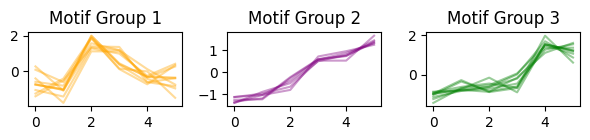

In [38]:
fig, axs = plt.subplots(1, len(motif_indices), figsize=(2 * len(motif_indices), 1.5), sharex=True)
if len(motif_indices) == 1:
    axs = [axs]

for i, indices in enumerate(motif_indices):
    ax = axs[i]
    ax.set_title(f"Motif Group {i+1}")

    color = colors[i % len(colors)]
    for idx in indices:
        subseq = series[idx:idx + m]
        if len(subseq) > 0:
          subseq_norm = znorm(subseq)
          ax.plot(subseq_norm, color=color, alpha=0.4)

plt.tight_layout()

For the discovery of motifs considering the patterns observed in multiple series (i.e., multidimensional), we will consider the Monthly Fuel Sales by State dataset. Specifically, the LPG sales observed in the 27 states.

In [39]:
result, flag = loader.monthly_sales_state()
df, metadata = loader.read_tsf(path_tsf=result)
df = df[df['product'] == 'LPG']

dataset downloaded at: ./monthly_fuel_sales_by_state.tsf


A simple solution for this problem consists on discovery motifs in a longer time series that concatenates the series from multiple dimensions

In [40]:
# Concatenating multiple time series into a single one
data = []
for i in range(len(df)):
  series = np.array(df.iloc[i]['series_value'])
  data.append(series)
data = np.array(data)
series_concatenated = data.flatten()

Finding the top-10 ($k=10$) motifs with patterns comprising 12 months ($m=12$)

In [41]:
m = 12
mp = stumpy.stump(series_concatenated, m)
k = 10
motif_distances, motif_indices = stumpy.motifs(series_concatenated, mp[:, 0], max_motifs=k)

Visualizing the discovered motifs in the concatenated time series

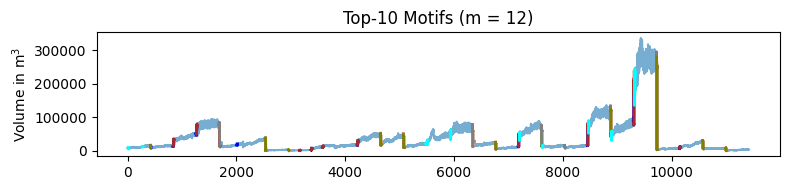

In [31]:
plt.figure(figsize=(8, 2))
plt.plot(series_concatenated, alpha=0.6)

for i in range(len(motif_indices)):
    for idx in motif_indices[i]:
        motif_segment = np.arange(idx, idx + m)
        plt.plot(motif_segment, series_concatenated[motif_segment], color=colors[i % len(colors)], linewidth=2)

plt.ylabel('Volume in m$^3$')
plt.title(f"Top-{k} Motifs (m = {m})")
plt.tight_layout()

For better visualization, we will analyze the motif groups separately and normalized.

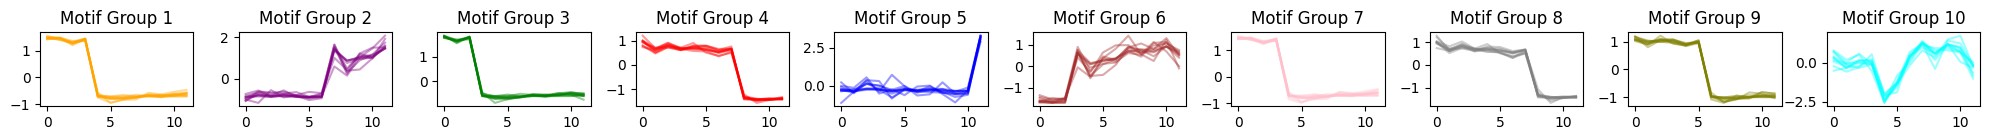

In [47]:
fig, axs = plt.subplots(1, len(motif_indices), figsize=(2 * len(motif_indices), 1.5), sharex=True)

if len(motif_indices) == 1:
    axs = [axs]

for i, indices in enumerate(motif_indices):
    ax = axs[i]
    ax.set_title(f"Motif Group {i+1}")

    color = colors[i % len(colors)]

    for idx in indices:
        subseq = series_concatenated[idx:idx + m]
        if len(subseq) > 0:
          subseq_norm = znorm(subseq)
          ax.plot(subseq_norm, color=color, alpha=0.4)

plt.tight_layout()